<a href="https://colab.research.google.com/github/petrussich/cultery/blob/main/cultery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Создаём путь к гугл диску

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

путь к папке с датасетом

In [ ]:
import shutil
import pathlib
dataset_path = '/content/drive/MyDrive/cultery/dataset/'
dataset_dir = pathlib.Path(dataset_path)

смотрим количество изображений

In [ ]:
image_count1 = len(list(dataset_dir.glob("*/*.jpg")))
image_count2 = len(list(dataset_dir.glob("*/*.png")))
image_count3 = len(list(dataset_dir.glob("*/*.jpeg")))
print(f"Всего изображений: {image_count1+image_count2+image_count3}")

Всего изображений: 3000


разделяем датасет на тренировочный и валидационный

In [ ]:
batch_size = 32
img_width = 180
img_height = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Found 3000 files belonging to 10 classes.
Using 600 files for validation.
Class names: ['bowl', 'chopsticks', 'corkscrew', 'cup', 'fork', 'knife', 'ladle', 'spatula', 'spoon', 'tongs']


архитектура нейронной сети

In [ ]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(img_width, img_height, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False
augment = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)
  ])

inputs = pretrained_model.input
x = augment(inputs)

x = tf.keras.layers.Dense(512, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.45)(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 180, 180, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 180, 180, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 180, 180, 3)          0         ['normalization[0][0]']   

тренируем нейросеть и рисуем графиик

Epoch 1/10
75/75 [==============================] - 220s 2s/step - loss: 2.9981 - accuracy: 0.2917 - val_loss: 1.1000 - val_accuracy: 0.7017
Epoch 2/10
75/75 [==============================] - 161s 2s/step - loss: 1.2184 - accuracy: 0.5800 - val_loss: 0.5700 - val_accuracy: 0.8467
Epoch 3/10
75/75 [==============================] - 164s 2s/step - loss: 0.8599 - accuracy: 0.7050 - val_loss: 0.3908 - val_accuracy: 0.8783
Epoch 4/10
75/75 [==============================] - 165s 2s/step - loss: 0.6231 - accuracy: 0.8004 - val_loss: 0.3570 - val_accuracy: 0.8867
Epoch 5/10
75/75 [==============================] - 153s 2s/step - loss: 0.6045 - accuracy: 0.8083 - val_loss: 0.2906 - val_accuracy: 0.9117
Epoch 6/10
75/75 [==============================] - 168s 2s/step - loss: 0.4611 - accuracy: 0.8454 - val_loss: 0.2925 - val_accuracy: 0.9033
Epoch 7/10
75/75 [==============================] - 170s 2s/step - loss: 0.4252 - accuracy: 0.8763 - val_loss: 0.3211 - val_accuracy: 0.9117
Epoch 8/10
75

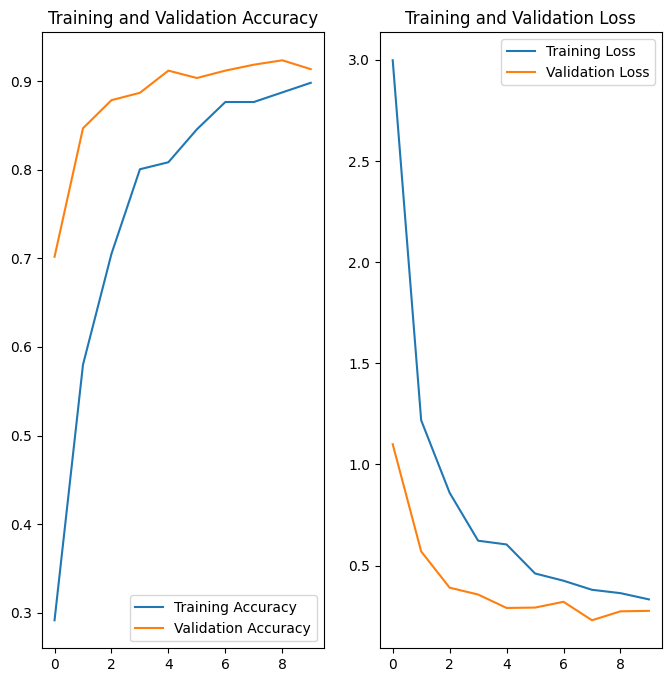

In [ ]:
epochs = 10
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)
# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

проверяем тестовую точность

In [ ]:
test_loss, test_accuracy = model.evaluate(val_ds)
print('Тестовая точность:', test_accuracy)

19/19 [==============================] - 33s 2s/step - loss: 0.2063 - accuracy: 0.9417
Тестовая точность: 0.9416666626930237


тестируем модель

In [ ]:
from PIL import Image
import requests
from io import BytesIO

image_path = '/content/drive/MyDrive/cultery/test/NewCanvas1.png'

img = Image.open(image_path)
img = img.resize((img_width, img_height))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))



1/1 [==============================] - 0s 70ms/step
На изображении скорее всего cup (23.20% вероятность)


In [ ]:
model.save('/content/drive/MyDrive/cultery/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


устанваливаем библиотеки по работе с тг

In [ ]:
!pip install -U aiogram
!pip install --force-reinstall -v "aiogram==2.23.1"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.8/546.8 kB 11.1 MB/s eta 0:00:00
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.4/164.4 kB 16.9 MB/s eta 0:00:00
  Using cached magic_filter-1.0.12-py3-none-any.whl (11 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

код для работы тг бота

In [ ]:
from aiogram import Bot, types, Dispatcher, executor
from aiogram.types import ContentType
bot = Bot(token='7071755141:AAFX0YmzPT_l5wkiVc5zfpITTYGM9XZrf8E')
dp = Dispatcher(bot)
class_names = ['bowl', 'chopsticks', 'corkscrew', 'cup', 'fork', 'knife', 'ladle', 'spatula', 'spoon', 'tongs']
model = keras.models.load_model('/content/drive/MyDrive/cultery/model.h5')

def cultery_predict(image_path):
    img = tf.keras.utils.load_img(
        image_path, target_size=(180, 180)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "Это же {}"
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    return(
        "Это же {}"
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

@dp.message_handler(commands=['start'])
async def process_start_command(message: types.Message):
    await message.reply("Нихао подошва")


@dp.message_handler(content_types=ContentType.PHOTO)
async def get_photo(message: types.Message):
    image_path = f'photos/{message.photo[0].file_id}.jpg'
    photos = message.photo
    await photos[0].download(destination=image_path)
    predict = cultery_predict(image_path)
    await message.reply(predict)


async def main():
    await dp.start_polling(bot)


await main()

/usr/local/lib/python3.10/dist-packages/aiogram/types/mixins.py:40: DeprecationWarning: destination parameter is deprecated, please use destination_dir or destination_file.
  warn_deprecated(


1/1 [==============================] - 2s 2s/step
Это же cup
